In [1]:
from fastai2.vision.all import *
from fastai2.vision.widgets import *

# The Amazing Bear Classifier!

You need to know whether you're being chased by a dangerous grizzly, or a sweet teddy bear, and you need an answer *fast*? Then you've come to the right place. Take a pic of the potentially vicious killer, and click 'upload' to classify it. (Important: this only handles grizzly bears, black bears, and teddy bears. It will **not** give a sensible answer for polar bears, a bear market, a bear of a man, or hot dogs.

----

In [2]:
defaults.use_cuda = False
learn_inf = torch.load('export.pkl', map_location='cpu')
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()

In [3]:
def on_click(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

In [4]:
btn_upload.observe(on_click, names=['data'])

In [5]:
display(VBox([widgets.Label('Select your bear!'), btn_upload, out_pl, lbl_pred]))

## Let's Make Our PairWise Similarity Envine

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
%config InlineBackend.figure_format='retina'
%matplotlib notebook
sns.set(rc={'figure.figsize':(15.7,8.27)})
np.set_printoptions(suppress=True)

In [2]:
import torch
from torchvision import models

In [3]:
model = models.alexnet(pretrained=True)

In [4]:
image_pairs = [
    ('JeanieCubs.jpg', 'BaldBear.jpg'),
    ('JeanieCubs.jpg', 'Gorilla.jpg')
]

In [5]:
import lib.nethook as nethook
from pathlib import Path
from torchvision import transforms

root_dir = Path('images')

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def compare_images(model, image_pairs):
    # create dataloader from image_pairs
    imgs = [root_dir/img for imgs in image_pairs for img in imgs]
    dataset = ImageListDataset(imgs=imgs, transform=transform)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=False)
    print(imgs)
    pass


In [6]:
from collections import OrderedDict

def get_activations(model, dataloader):
    '''use nethook to retain features for all model layers'''
    from pprint import pprint
    print("==> Getting Activations")

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    layer_names = get_layers(model, parent_name='', layer_info=[])
    pprint(layer_names)

    if not isinstance(model, nethook.InstrumentedModel):
        model = nethook.InstrumentedModel(model)
    for layer_name in layer_names: model.retain_layer(layer_name)

    # we only need a single forward pass because the dataset is small:
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        imgs, labels, indexes = next(iter(dataloader))
        model(imgs.to(device))
        
    return layer_names, model

def get_layer(m, layers):
    layer = layers.pop(0)
    m = getattr(m, layer)
    if len(layers) > 0:
        return get_layer(m, layers)
    return m

def get_layers(model, parent_name='', layer_info=[]):
    for module_name, module in model.named_children():
        layer_name = parent_name + '.' + module_name
        if len(list(module.named_children())):
            layer_info = get_layers(module, layer_name, layer_info=layer_info)
        else:
            layer_info.append(layer_name.strip('.'))
    
    return layer_info

def get_layer_type(model, layer_name):
    m = get_layer(model, layer_name.split("."))
    return m.__class__.__name__

def convert_relu_layers(parent):
    for child_name, child in parent.named_children():
        if isinstance(child, nn.ReLU):
            setattr(parent, child_name, nn.ReLU(inplace=False))
        elif len(list(child.children())) > 0:
            convert_relu_layers(child)
            
def store_activations(model, layer_names):
    a = OrderedDict()
    for layer_num, layer_name in enumerate(layer_names):
        layer_type = get_layer_type(model.model, layer_name)
        X = model.retained_layer(layer_name)        
        X = X.view(X.shape[0],-1)
        a[layer_name] = X
    return a            

In [55]:
import os
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader, random_split
from glob import glob
from pathlib import Path
from PIL import Image
from PIL import Image

class ImageListDataset(Dataset):
    """"""
    def __init__(self, imgs, transform=None):
        self.root_dir = None
        self.files = imgs
        self.transform = transform
                            
    def __getitem__(self, index):
        im = Image.open(self.files[index])
        if self.transform:
            im = self.transform(im)
                            
        return im, 0, index

    def __len__(self):
        return len(self.files)    
    
    def __repr__(self):
        _repr_indent = 4
        head = "Dataset " + self.__class__.__name__
        body = ["Number of Images: {}".format(self.__len__())]
        if self.root_dir is not None:
            body.append("Root location: {}".format(self.root_dir))
        if hasattr(self, "transform") and self.transform is not None:
            body += [repr(self.transform)]        
        lines = [head] + [" " * _repr_indent + line for line in body]
        return '\n'.join(lines)

def get_dataset(image_pairs):
    transform = transforms.Compose([
        transforms.Resize((224,224)),
    ])
    imgs = [root_dir/img for imgs in image_pairs for img in imgs]
    dataset = ImageListDataset(imgs=imgs, transform=transform)
    
    return dataset

def stack_imgs(dataset):
    imgs = []
    for image_num in range(0, len(dataset), 2):
        imgs.append(np.hstack([np.array(dataset[image_num][0]), np.array(dataset[image_num+1][0])]))
    imgs = np.vstack(imgs)
    
    return Image.fromarray(imgs)


In [8]:
root_dir = Path('images')
imgs = [root_dir/img for imgs in image_pairs for img in imgs]
dataset = ImageListDataset(imgs=imgs, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=False)
dataset, dataloader

(Dataset ImageListDataset
     Number of Images: 4
     Compose(
     Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ), <torch.utils.data.dataloader.DataLoader at 0x7f9258f3e208>)

In [9]:
for img, image_name, index in dataloader:
    print(img.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


In [10]:
img.shape

torch.Size([1, 3, 224, 224])

In [11]:
import torch

layer_names, model = get_activations(model, dataloader)

==> Getting Activations
['features.0',
 'features.1',
 'features.2',
 'features.3',
 'features.4',
 'features.5',
 'features.6',
 'features.7',
 'features.8',
 'features.9',
 'features.10',
 'features.11',
 'features.12',
 'avgpool',
 'classifier.0',
 'classifier.1',
 'classifier.2',
 'classifier.3',
 'classifier.4',
 'classifier.5',
 'classifier.6']


In [12]:
import pandas as pd
from scipy.stats import pearsonr
from fastprogress import master_bar, progress_bar

device = 'cuda' if torch.cuda.is_available() else 'cpu'

df = pd.DataFrame(columns=['pair_num', 'image1', 'image2', 'layer_num', 'layer_name', 'layer_type', 'r'])

pair_num = 0
mb = master_bar(dataloader)
for count, (imgs, labels, indexes) in enumerate(mb):
    model(imgs.to(device))
    if count % 2 == 0:
        a1 = store_activations(model, layer_names)
        image1 = dataset.files[indexes].name
    if count % 2 == 1:
        a2 = store_activations(model, layer_names)
        image2 = dataset.files[indexes].name
        for layer_num, layer_name in enumerate(progress_bar(layer_names, parent=mb)):
            r = pearsonr(a1[layer_name].squeeze(), a2[layer_name].squeeze())[0]
            layer_type = get_layer_type(model.model, layer_name)
            df = df.append({
                "pair_num": pair_num,
                "image1": image1,
                "image2": image2,
                "layer_num": layer_num,
                "layer_name": layer_name,
                "layer_type": layer_type,
                "r": r,                
            }, ignore_index=True)
            
        pair_num += 1

In [13]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from glob import glob
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from IPython.core.debugger import set_trace

alexnet_pytorch_blocks = OrderedDict([
    ('Conv1', ['features.0','features.1','features.2']),
    ('Conv2', ['features.3','features.4','features.5']),
    ('Conv3', ['features.6','features.7']),
    ('Conv4', ['features.8','features.9']),
    ('Conv5', ['features.10','features.11','features.12']),
    ('', ['avgpool']),
    ('fc6', ['classifier.0','classifier.1','classifier.2']),
    ('fc7', ['classifier.3','classifier.4','classifier.5']),
    ('fc8', ['classifier.6']),
])

In [30]:
def plot_df(df, pairs=[0,1], title='', blocks=None, legend_loc=(0.79, 0.80), group_by='pair_num', ceiling=1, ylabel='correlation'):

    ax = plot_data(df[df.pair_num.isin(pairs)], title, ymax=1.10, ymin=-0.20, hue=group_by, ylabel=ylabel)
    
    if blocks:
        draw_bg(blocks, ypos=1.03, legend_loc=legend_loc)
    
    L = ax.legend()
    legend_labels = ['image_pair']
    for pair in pairs:
        label = df[df.pair_num == pair].iloc[0].image1.replace('.jpg', '') + '_vs_' + df[df.pair_num == pair].iloc[0].image2.replace('.jpg', '')
        legend_labels.append(label)        
    for label_num, label in enumerate(legend_labels):
        if label is not None: L.get_texts()[label_num].set_text(label)
        
    return ax

def plot_data(df, title, ymax=.50, ymin=0.0, hue=None, ylabel='correlation'):
    sns.set(rc={'figure.figsize':(16.7,8.27)})
    sns.set_style("whitegrid", {'axes.grid' : False})
    ax = sns.lineplot(x="layer", y="y", hue=hue, data=df, linewidth=2)
    ax.set_title(title, fontsize=24);
    ax.set_ylabel(ylabel, fontsize=24, labelpad=15);
    ax.set_xlabel("layer", fontsize=24, labelpad=20);
    ax.set_ylim([ymin, ymax])
    plt.xticks(rotation=90);
    
    return ax

def draw_bg(blocks, ypos=0.475, alpha_b=.20, alpha_g=.15, legend_loc=(0.79, 0.80)):
    if blocks == None: return
    c = 0
    for idx, (block_name, layers) in enumerate(blocks.items()):
        n_layers = len(layers)
        for i in range(c, c+n_layers):
            if idx % 2 == 0:
                plt.axvspan(i-.5, i+.5, facecolor='b', alpha=alpha_b, lw=0)
            else:
                plt.axvspan(i-.5, i+.5, facecolor='gray', alpha=alpha_g, lw=0)
        plt.text(c+(n_layers)/2-.5, ypos, block_name, fontdict=None, fontsize=16, ha='center', va='center')
        c += n_layers
    plt.legend(facecolor=(0.95,0.95,0.95,1.0), bbox_to_anchor=legend_loc) 
    
def plot(df):
    df['y'] = df['r']
    layer_name = lambda x: "{:02d}_{}".format(x.layer_num,x.layer_type.replace("BatchNorm2d","Norm").replace("GroupNorm", "Norm"))
    df['layer'] = df[['layer_num','layer_type']].apply(layer_name, axis=1)
    
    blocks = alexnet_pytorch_blocks
    return plot_df(df, blocks=blocks)


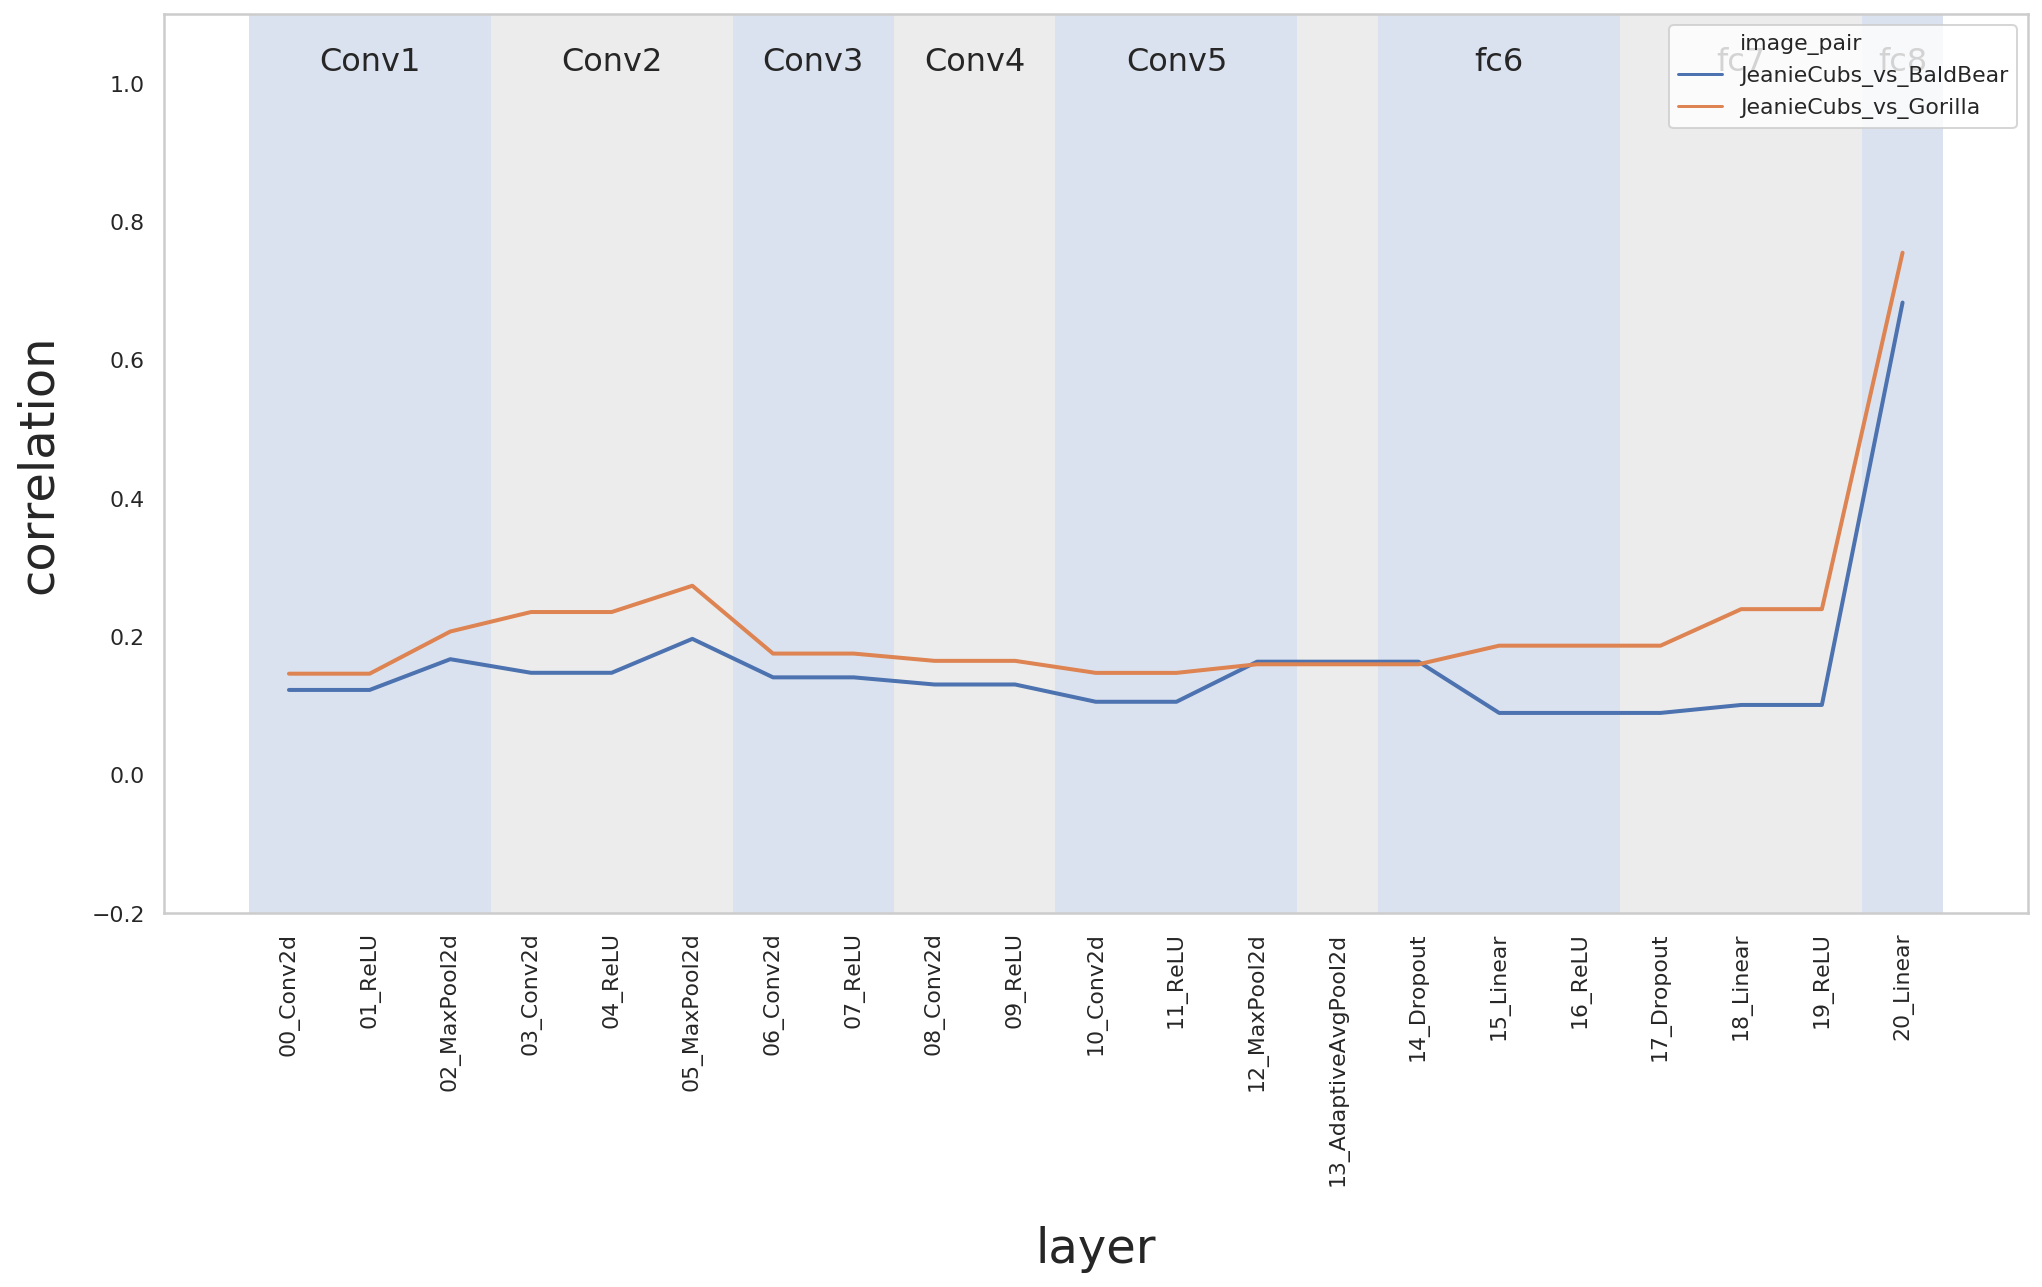

In [31]:
ax = plot(df)

In [56]:
dataset = get_dataset(image_pairs)
dataset

Dataset ImageListDataset
    Number of Images: 4
    Compose(
    Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
)

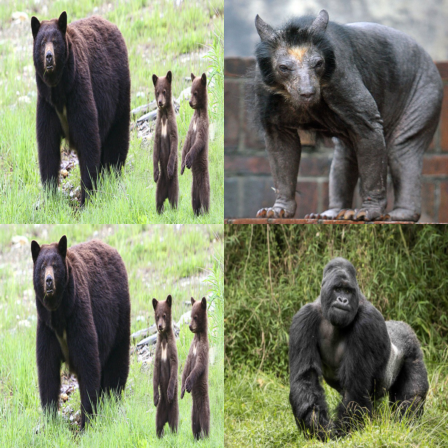

In [57]:
stack_imgs(dataset)